In [62]:
import numpy as np
import pandas as pd
import seaborn as sns

In [63]:
from scipy.signal import find_peaks, savgol_filter
from scipy.special import wofz
import scipy.stats
from scipy.optimize import curve_fit
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut, rubberband_baseline_cor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA, FactorAnalysis, NMF

In [64]:
# import matplotlib as mpl
# mpl.use('pgf')
# mpl.rcParams.update({
#     "pgf.texsystem": "pdflatex",  # Use pdflatex for rendering
#     'font.family': 'serif',       # Use serif font family
#     'text.usetex': True,          # Use LaTeX for text rendering
#     'pgf.rcfonts': False,         # Don't setup fonts from rc params
#     'pgf.preamble': r'\usepackage{amsmath,amsfonts,amssymb}\usepackage[T2A,T1]{fontenc}\usepackage[utf8]{inputenc}\usepackage[ukrainian]{babel}',  # Use Ukrainian Cyrillic font
#     'font.size': 10               # Set font size
# })

In [65]:
import os

In [66]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [67]:
import sys
sys.path.append('../tools')
from analysis import *
# from curve_fitting import *

In [68]:
# pd.options.display.float_format = '{:.5f}'.format

<Axes: >

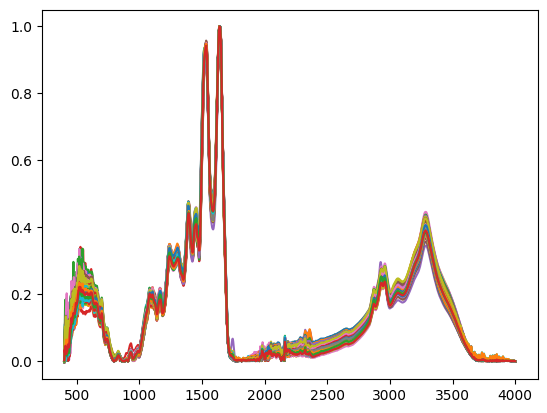

In [69]:
domain = pd.read_csv("../data/domain.csv").to_numpy().reshape(1, -1)[0]
df = pd.read_csv('../data/dataset.csv')
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

df = df.drop(columns='years')

X_raw = df.drop(columns='HbA1c')
X_raw.columns = np.ravel(domain)
#X = X.apply(lambda row: row / row.max(), axis=1)
X = X_raw.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=1)).T
X = X.apply(lambda row: row / row.max(), axis=1)
#X = X_raw.apply(lambda row: row / np.linalg.norm(row), axis=1)

y = df['HbA1c']
X.T.plot(legend=False)

In [70]:
def combined_pseudo_voigt(x, *params):
    """ 
    Voigt profile approximation by linear combination of
    Lorenzian and Gaussian distributinos.
    mu, A, A0, FWHM, eta
    """
    N = len(params) // 5
    result = np.zeros_like(x)
    for i in range(N):
        mu, gamma_gaussian, gamma_lorentzian, amplitude, eta = params[i*5:(i+1)*5]
        
        a_G = (2 / gamma_gaussian) * np.sqrt(np.log(2) / np.pi)
        b_G = (4 * np.log(2)) / (gamma_gaussian**2)
        gaussian_term = a_G * np.exp(-b_G * (x - mu)**2)
        
        lorentzian_term = (1 / np.pi) * ( (gamma_lorentzian / 2) / ( (x - mu)**2 + (gamma_lorentzian / 2)**2) ) 
        
        result += amplitude * (eta * gaussian_term + (1 - eta) * lorentzian_term)

    return result

In [71]:
def corr_plot(X, y):
    fig, ax = plt.subplots()
    
    r, p_val = pearsonr(X, y)
    
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(min(X), max(X))
    predicted = model.predict(x_range.reshape(-1, 1))
    
    if p_val < 0.00001:
        text = f"$R = {r:.2f}$\n$p < 0.00001$\n$y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}$"
    else:
        text = f"$R = {r:.2f}$\n$p = {p_val:.2f}$\n$y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}$"
        
    ax.scatter(X, y, facecolor='w', edgecolor='k', s=30)
    ax.plot(x_range, predicted, color='r', linewidth=1.5)
    ax.set_xlabel("$y_1$")
    ax.set_ylabel("$y_2$")

    x_offset = (max(X) - min(X)) * 0.02
    y_offset = (max(y) - min(y)) * 0.02
    text_x = min(X)
    text_y = max(y)

    print(text)
    
    ax.text(text_x, text_y, text, verticalalignment='top')
    
    return fig, ax

In [72]:
def get_secondary_structure(areas_df):
    intermol_beta_sheet = areas_df['1611-1614'] + areas_df['1616-1619'] + areas_df['1622-1626']
    beta_sheet = areas_df['1627-1630'] + areas_df['1631-1634'] + areas_df['1635-1638'] + areas_df['1639-1641']
    random_coil = areas_df['1643-1646'] + areas_df['1646-1649']
    alpha_helix = areas_df['1650-1654'] + areas_df['1655-1657']
    beta_turn = (areas_df['1659-1663'] + areas_df['1665-1670'] + 
                 areas_df['1672-1675'] + areas_df['1678-1680'] + 
                 areas_df['1681-1685'] + areas_df['1686-1689'] +
                 areas_df['1693-1696'] + areas_df['1698-1700']
                )
    result = {
        "intermol beta sheet": intermol_beta_sheet,
        "beta sheet": beta_sheet,
        "random coil": random_coil,
        "alpha helix": alpha_helix,
        "beta turn": beta_turn, 
        "all beta": intermol_beta_sheet + beta_sheet + beta_turn
    }
    
    return pd.DataFrame(result)

In [73]:
def make_plot(x_values, params):
    """ Makes plot using parameters from pseudo voigt fitting """
    y_peaks = []
    
    plt.figure(figsize=(8, 5))
    
    for index, row in params.iterrows():
        y_pred = combined_pseudo_voigt(x_values, *row[['wavenumber', 'gamma_gauss', 'gamma_lorentz', 'amplitude', 'eta']])
        plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)

    #plt.plot(x_values, y_values, color='r')
    plt.plot(x_values, y_peaks.sum(axis=0), color='k')
    plt.xlim([min(x_values), max(x_values)])
    #plt.ylim([0, 1.1])
    plt.xlabel("Хвильове число")

def make_plot_amide(x_values, params):
    """ Makes plot using parameters from pseudo voigt fitting """
    y_peaks = []
    added_labels = {}
    
    plt.figure(figsize=(6.5, 4))
    
    for index, row in params.iterrows():
        y_pred = combined_pseudo_voigt(x_values, *row[['wavenumber', 'gamma', 'amplitude', 'eta']], 0)
        peak = x_values[np.argmax(y_pred)]

        if 1610 < peak < 1627:
            color = 'blue'
            label = r'Intermolecular $\beta$-sheet'
        elif 1628 < peak < 1642:
            color = 'green'
            label = r'$\beta$-sheet'
        elif 1643 < peak < 1650:
            color = 'red'
            label = r'Random coil'
        elif 1650 < peak < 1659:
            color = 'orange'
            label = r'$\alpha$-helix and Gln side chain'
        elif 1659 < peak < 1700:
            color = 'purple'
            label = r'$\beta$-turn'
        else:
            color = 'black'
            label = None

        if label and label not in added_labels:
            plt.fill_between(x_values, y_pred, color=color, alpha=0.1, label=label)
            added_labels[label] = True
        else:
            plt.fill_between(x_values, y_pred, color=color, alpha=0.1)
        
        plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)
    
    #plt.plot(x_values, y_values, color='b')
    plt.plot(x_values, y_peaks.sum(axis=0), color='k')
    plt.xlim([min(x_values), max(x_values)])
    plt.ylim([0, 1.1])
    plt.legend(fontsize=8)
    plt.xlabel("Хвильове число")

In [74]:
params = pd.read_csv("../data/fits/fit_1250_2750_w5_o3/101_pseudo_voigt_fit_5.0.csv")
params

,Unnamed: 0,peak_found,wavenumber,gamma_gauss,gamma_lorentz,amplitude,eta,FWHM,area
0,0,1012.462,1016.298833,0.009409,3.326937,0.022385,1.770336e-01,3.628645,0.000068
1,1,1028.854,1029.904887,3.523052,13.502384,0.387743,3.018050e-24,13.899859,0.001370
2,2,1047.657,1043.811723,3.149142,19.094914,0.767309,5.413297e-35,19.661823,0.002722
3,3,1050.067,1055.058781,3.405713,27.808548,1.841701,2.864599e-31,27.963000,0.006448
4,4,1082.370,1080.549209,1.454048,40.137047,7.050199,1.393330e-04,40.499000,0.024657
...,...,...,...,...,...,...,...,...,...
62,62,1687.436,1687.536887,8.914155,11.449980,2.231759,4.327654e-01,10.042423,0.008336
63,63,1694.668,1694.401911,6.395299,8.436444,1.147640,5.699281e-02,8.667466,0.004226
64,64,1699.007,1699.074630,5.515272,3.728537,0.177572,1.318187e-02,4.231861,0.000667
65,65,1703.828,1703.765970,17.628841,6.925869,0.508472,6.549747e-01,12.319627,0.001918


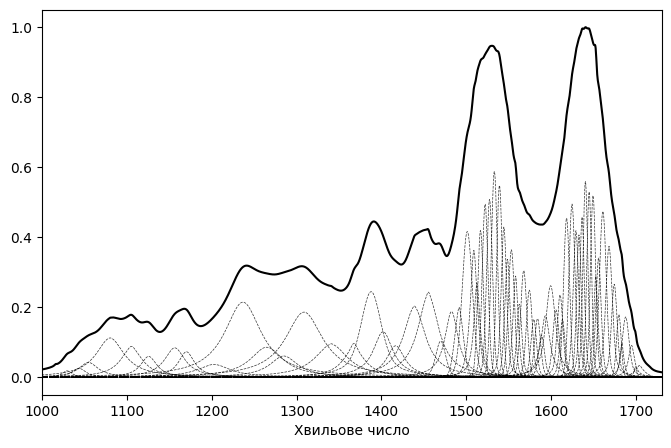

In [75]:
make_plot(np.linspace(1000, 1730, 2000), params)

In [76]:
columns = pd.read_csv("../data/peak_means")['0'].astype(np.int32)
columns

0     1012
1     1029
2     1047
3     1051
4     1080
      ... 
62    1687
63    1694
64    1699
65    1703
66    1717
Name: 0, Length: 67, dtype: int32

In [77]:
peaks = pd.read_csv("../data/peaks.csv")
peaks_mean = peaks.mean(axis=0).astype(np.int32)

In [78]:
amide_columns = peaks_mean.index[40:-2]
amide_columns

Index(['1581-1584', '1585-1587', '1588-1592', '1600-1603', '1604-1606',
       '1608-1610', '1611-1614', '1616-1619', '1622-1626', '1627-1630',
       '1631-1634', '1635-1638', '1639-1641', '1643-1646', '1646-1649',
       '1650-1654', '1655-1657', '1659-1663', '1665-1670', '1672-1675',
       '1678-1680', '1681-1685', '1686-1689', '1693-1696', '1698-1700'],
      dtype='object')

In [79]:
path = "../data/fits/fit_1250_2750_NoSG/"
# path = "../data/fits/fit_1250_2750_vn/"
# path = "../data/fits/fit_1040_2750/"

areas = []
fwhms = []
wavenumbers = []
amplitude = []
gamma_g = []
gamma_l = []
eta = []
hba1c = []
age = []

for file in os.listdir(path):
    filename = os.path.splitext(file)[0]
    
    hba1c_value = filename.split("_")[-2]
    age_value = filename.split("_")[-1]
    
    hba1c.append(float(hba1c_value))
    age.append(int(age_value))
    
    result = pd.read_csv(os.path.join(path, file)).iloc[:, 1:]
    
    areas.append(result['area'].to_numpy())
    fwhms.append(result['FWHM'].to_numpy())
    wavenumbers.append(result['wavenumber'].to_numpy())
    amplitude.append(result['amplitude'].to_numpy())

    gamma_g.append(result['gamma_gauss'].to_numpy())
    gamma_l.append(result['gamma_lorentz'].to_numpy())
    eta.append(result['eta'].to_numpy())


age = np.array(age)
hba1c = np.array(hba1c)

wavenumbers = pd.DataFrame(wavenumbers, columns=columns)
areas = pd.DataFrame(areas, columns=columns) * 100
fwhms = pd.DataFrame(fwhms, columns=columns)
amplitude = pd.DataFrame(amplitude, columns=columns)

In [80]:
areas['HbA1c'] = hba1c
areas['age'] = age
areas.corr()['HbA1c'].abs().sort_values(ascending=False).head(10)

0
HbA1c    1.000000
1012     0.569773
1029     0.494858
1080     0.339865
1159     0.284151
1415     0.271709
1567     0.266687
1617     0.254930
1644     0.242634
1652     0.242460
Name: HbA1c, dtype: float64

$R = 0.57$
$p < 0.00001$
$y = 33.04x + 4.52$


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$y_1$', ylabel='$y_2$'>)

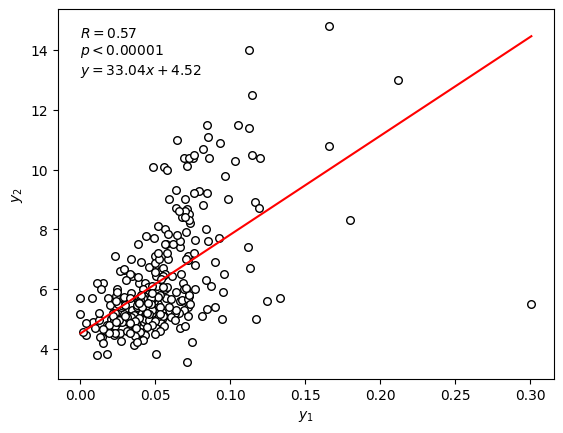

In [81]:
corr_plot(areas[1012].to_numpy(), hba1c)

In [82]:
fwhms['HbA1c'] = hba1c
fwhms['age'] = age
fwhms.corr()['HbA1c'].abs().sort_values(ascending=False).head(10)

0
HbA1c    1.000000
1683     0.349506
1548     0.316836
1415     0.297632
1401     0.292281
1557     0.288211
1159     0.254731
1652     0.246821
1699     0.239634
1513     0.222305
Name: HbA1c, dtype: float64

In [83]:
delta = peaks_mean.to_numpy() - wavenumbers
delta['HbA1c'] = hba1c
delta['age'] = age
delta.corr()['HbA1c'].abs().sort_values(ascending=False).head(20)

0
HbA1c    1.000000
1563     0.377498
1717     0.374400
1683     0.371547
1415     0.361342
1687     0.358671
1439     0.348609
1624     0.313300
1660     0.294935
1617     0.288593
1467     0.283664
1552     0.278924
1647     0.276683
1567     0.267259
1452     0.248899
1389     0.247070
1401     0.246330
1703     0.238753
1557     0.236266
1308     0.234067
Name: HbA1c, dtype: float64

In [84]:
amplitude['HbA1c'] = hba1c
amplitude['age'] = age
amplitude.corr()['HbA1c'].abs().sort_values(ascending=False).head(15)

0
HbA1c    1.000000
1012     0.520047
1029     0.484804
1080     0.327482
1159     0.279763
1415     0.263019
1652     0.252570
1567     0.247784
1644     0.233963
1617     0.232431
1683     0.230338
1401     0.229711
1513     0.207024
1169     0.195458
1624     0.192272
Name: HbA1c, dtype: float64

In [90]:
peak_names_amide = peaks_mean[(peaks_mean.to_numpy() > 1580) & (peaks_mean.to_numpy() < 1700)].to_numpy()
path = "../data/fits/fit_amide1_w5_o3/"
areas_amide = []
fwhms_amide = []
wavenumbers_amide = []
amplitude_amide = []
hba1c_amide = []

for file in os.listdir(path):
    filename = os.path.splitext(file)[0]
    
    hba1c_p = filename.split("_")[-1]
    hba1c_amide.append(float(hba1c_p))
    
    result = pd.read_csv(os.path.join(path, file)).iloc[:, 1:]
    areas_amide.append(result['area'].to_numpy())
    wavenumbers_amide.append(result['wavenumber'].to_numpy())
    fwhms_amide.append(result['FWHM'].to_numpy())
    amplitude_amide.append(result['amplitude'].to_numpy())

hba1c_amide = pd.Series(hba1c_amide)
areas_amide = pd.DataFrame(areas_amide, columns=amide_columns) * 100
areas_amide['HbA1c'] = hba1c_amide

In [91]:
secondary_structure = get_secondary_structure(areas_amide)
secondary_structure['HbA1c'] = hba1c_amide
secondary_structure

,intermol beta sheet,beta sheet,random coil,alpha helix,beta turn,all beta,HbA1c
0,15.086180,25.476339,14.815933,13.175982,25.153431,65.715950,7.50
1,15.859454,25.206803,14.891326,11.407329,26.251659,67.317916,5.62
2,17.176139,25.719074,15.734148,9.119963,25.942697,68.837911,5.00
3,17.098230,25.537657,13.624393,11.404639,26.417596,69.053482,5.52
4,17.096920,25.612390,16.300906,7.961568,26.073779,68.783089,7.00
...,...,...,...,...,...,...,...
289,17.173995,24.509061,17.647267,6.897184,27.269364,68.952419,4.72
290,15.910873,24.647625,16.024433,9.338315,27.042156,67.600654,5.55
291,15.951620,26.008839,13.319864,10.474837,27.636882,69.597341,5.17
292,15.700133,26.181278,16.466775,8.306218,27.216673,69.098084,5.20


In [92]:
areas_amide.corr()['HbA1c'].abs().sort_values(ascending=False)

HbA1c        1.000000
1588-1592    0.349134
1643-1646    0.321693
1627-1630    0.282880
1678-1680    0.263394
1650-1654    0.246637
1681-1685    0.230021
1659-1663    0.229830
1604-1606    0.229141
1686-1689    0.205558
1622-1626    0.194229
1600-1603    0.185106
1655-1657    0.184346
1672-1675    0.169301
1581-1584    0.142920
1616-1619    0.111151
1635-1638    0.102529
1665-1670    0.091430
1639-1641    0.083801
1646-1649    0.076633
1631-1634    0.064366
1693-1696    0.059514
1611-1614    0.047529
1585-1587    0.023248
1698-1700    0.018910
1608-1610    0.006867
Name: HbA1c, dtype: float64

In [ ]:
db = secondary_structure[secondary_structure['HbA1c'] >= 6.5].drop(columns=['HbA1c'])
hl = secondary_structure[secondary_structure['HbA1c'] < 6.5].drop(columns=['HbA1c'])
db

,intermol beta sheet,beta sheet,random coil,alpha helix,beta turn,all beta
0,15.086180,25.476339,14.815933,13.175982,25.153431,65.715950
4,17.096920,25.612390,16.300906,7.961568,26.073779,68.783089
25,16.888609,24.211493,16.089822,7.944598,28.644871,69.744972
29,15.334912,25.667780,16.452865,9.602447,26.778625,67.781317
44,15.857603,26.364462,16.056437,7.880161,27.735411,69.957476
...,...,...,...,...,...,...
216,15.198563,25.564348,15.428273,9.708435,26.586944,67.349855
218,17.717704,24.740393,17.070180,6.248449,27.440506,69.898602
226,14.526664,25.917817,15.862367,6.087119,29.622979,70.067461
242,15.378083,23.281298,13.520700,12.840551,27.835228,66.494608


In [ ]:
hl['alpha helix'].mean()

9.252299201358124

In [ ]:
db['alpha helix'].mean()

10.428457251915827

In [ ]:
hl['intermol beta sheet'].mean()

16.346937228322595

In [ ]:
db['intermol beta sheet'].mean()

15.717798004681622

alpha helix 4.383385052458243e-06


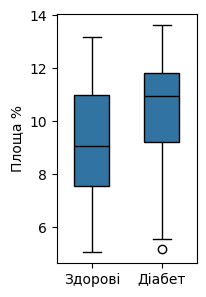

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind

def make_boxplot(db, hl, column):
    plt.figure(figsize=(2, 2.8))

    u_statistic, p_value = ttest_ind(db[column], hl[column])
    # u_statistic, p_value = mannwhitneyu(db[column], hl[column])
    combined_data = pd.DataFrame({
    'Values': hl[column].tolist() + db[column].tolist(),
    'Group': ['Здорові'] * len(hl[column]) + ['Діабет'] * len(db[column])
    })
    
    sns.boxplot(x='Group', y='Values', data=combined_data, width=0.5, linewidth=1, linecolor='k')

    # if column == "alpha helix":
    #     plt.title(r"$\alpha$-спіраль")
    # elif column == "intermol beta sheet":
    #     plt.title(r"Інтермол. $\beta$-лист")

    plt.ylabel('Площа %')
    plt.xlabel("")
    print(column, p_value)

make_boxplot(db, hl, "alpha helix")
plt.subplots_adjust(top=1, left=0.2)
# plt.savefig("../figures/alpha_helix.pgf", transparent=True)

intermol beta sheet 1.022691678139887e-07


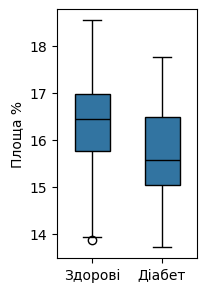

In [ ]:
make_boxplot(db, hl, "intermol beta sheet")
plt.subplots_adjust(top=1, left=0.2)
# plt.savefig("../figures/intermol_beta.pgf", transparent=True)

beta turn 0.029114093898549534


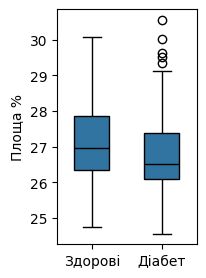

In [ ]:
make_boxplot(db, hl, "beta turn")
plt.subplots_adjust(top=0.95, left=0.2)
# plt.savefig("../figures/intermol_beta.pgf", transparent=True)

In [ ]:
hl['all beta'].mean()

68.84808629136442

In [ ]:
db['all beta'].mean()

68.33787627060441

In [ ]:
# def factors_plot(x_values, params, amplitude_df, n_components=20, factor=0):
#     """ Makes plot using parameters from pseudo voigt fitting """
#     y_peaks = []

#     fa = FactorAnalysis(n_components=n_components)
#     fa.fit(amplitude_df)
#     loadings_amplitude = fa.components_

#     plt.figure(figsize=(8, 3))
    
#     for index, row in params.iterrows():
#         wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta = row[['wavenumber', 'gamma_gauss', 'gamma_lorentz', 'amplitude', 'eta']]
        
#         # amplitude = amplitude * loadings_amplitude[factor, index]
        
#         y_pred = combined_pseudo_voigt(x_values, wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta)
#         y_pred = y_pred * loadings_amplitude[factor, index]
        
#         plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
#         y_peaks.append(y_pred)
    
#     y_peaks = np.array(y_peaks)

#     plt.plot(x_values, y_peaks.sum(axis=0), color='k')
#     plt.xlim([min(x_values), max(x_values)])
#     plt.xlabel("Хвильове число")

# for i in range(10):
#     factors_plot(np.linspace(1000, 1730, 2000), params, 
#                  amplitude.drop(columns='HbA1c'), 
#                  n_components=100, factor=i)
#     plt.title(f"PC {i + 1}")

In [ ]:
# path = "../data/fits/fit_1250_2750_w5_o3/"
# y_combined = []

# for file in os.listdir(path):
#     filename = os.path.splitext(file)[0]
#     params = pd.read_csv(os.path.join(path, file)).iloc[:, 1:]

#     x_values = X.iloc[:, 1250:2750].columns.to_numpy()
    
#     y_sample = np.zeros_like(x_values)
    
#     for index, row in params.iterrows():
#         wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta = row[['wavenumber', 'gamma_gauss', 'gamma_lorentz', 'amplitude', 'eta']]
        
        
#         y_pred = combined_pseudo_voigt(x_values, wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta)
        
#         # plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
#         y_sample += y_pred
    
#     y_combined.append(y_sample)

# y_combined = np.array(y_combined)

In [ ]:
wavenumbers_amide = pd.DataFrame(wavenumbers_amide, columns=amide_columns)
wavenumbers_amide['HbA1c'] = hba1c_amide

db_wn = wavenumbers_amide[wavenumbers_amide['HbA1c'] >= 6.5]
hl_wn = wavenumbers_amide[wavenumbers_amide['HbA1c'] < 6.5]

delta_amides = []

for column in db_wn.columns[:-1]:  # Exclude the 'HbA1c' column
    u_statistic, p_value = mannwhitneyu(db_wn[column], hl_wn[column])
    
    # Calculate mean values
    mean_db_wn = db_wn[column].mean()
    mean_hl_wn = hl_wn[column].mean()

    delta_amide = mean_db_wn - mean_hl_wn
    delta_amides.append(delta_amide)
    
    if p_value < 0.0001:
        print(f"{column} | p-value: {p_value:.5e} | Mean (>=6.5%): {mean_db_wn:.4f} | Mean (<6.5%): {mean_hl_wn:.4f} | delta: {delta_amide:.3f}")

np.mean(np.abs(delta_amides))

1600-1603 | p-value: 1.27437e-07 | Mean (>=6.5%): 1600.8287 | Mean (<6.5%): 1601.5306 | delta: -0.702
1611-1614 | p-value: 1.10872e-05 | Mean (>=6.5%): 1613.1180 | Mean (<6.5%): 1613.1708 | delta: -0.053
1622-1626 | p-value: 9.28470e-08 | Mean (>=6.5%): 1624.2180 | Mean (<6.5%): 1624.4157 | delta: -0.198
1643-1646 | p-value: 9.13481e-05 | Mean (>=6.5%): 1644.3931 | Mean (<6.5%): 1644.6380 | delta: -0.245
1646-1649 | p-value: 6.76267e-12 | Mean (>=6.5%): 1648.5522 | Mean (<6.5%): 1649.0687 | delta: -0.516
1655-1657 | p-value: 1.02565e-10 | Mean (>=6.5%): 1655.6886 | Mean (<6.5%): 1655.5244 | delta: 0.164
1659-1663 | p-value: 3.69868e-05 | Mean (>=6.5%): 1660.5295 | Mean (<6.5%): 1660.3510 | delta: 0.178
1672-1675 | p-value: 1.40254e-08 | Mean (>=6.5%): 1674.1887 | Mean (<6.5%): 1674.0131 | delta: 0.176
1681-1685 | p-value: 2.91151e-05 | Mean (>=6.5%): 1683.0670 | Mean (<6.5%): 1683.0224 | delta: 0.045
1686-1689 | p-value: 6.75304e-06 | Mean (>=6.5%): 1687.5259 | Mean (<6.5%): 1687.1571 

0.1935614463073125

In [ ]:
# fwhms_amide = pd.DataFrame(fwhms_amide, columns=amide_columns)
# fwhms_amide['HbA1c'] = hba1c_amide

# db_fwhm = fwhms_amide[fwhms_amide['HbA1c'] >= 6.5]
# hl_fwhm = fwhms_amide[fwhms_amide['HbA1c'] < 6.5]

# for column in db_fwhm.columns[:-1]:  # Exclude the 'HbA1c' column
#     u_statistic, p_value = mannwhitneyu(db_fwhm[column], hl_fwhm[column])
    
#     # Calculate mean values
#     mean_db_fwhm = db_fwhm[column].mean()
#     mean_hl_fwhm = hl_fwhm[column].mean()

    
#     if p_value < 0.0001:
#         print(f"{column} | p-value: {p_value:.5e} | Mean (>=6.5%): {mean_db_fwhm:.4f} | Mean (<6.5%): {mean_hl_fwhm:.4f}")

#         combined_data = pd.DataFrame({
#         'Values': hl_fwhm[column].tolist() + db_fwhm[column].tolist(),
#         'Group': ['Здорові'] * len(hl_fwhm[column]) + ['Діабет'] * len(db_fwhm[column])
#         })

#         plt.figure(figsize=(2, 3))
#         plt.xlabel("")
#         plt.ylabel("FWHM")
#         plt.title(column)
#         sns.boxplot(x='Group', y='Values', data=combined_data, width=0.5, linewidth=1, linecolor='k')
#         plt.show()

In [ ]:
# amplitude_amide = pd.DataFrame(amplitude_amide, columns=amide_columns)
# amplitude_amide['HbA1c'] = hba1c_amide

# db_amplitude = amplitude_amide[amplitude_amide['HbA1c'] >= 6.5]
# hl_amplitude = amplitude_amide[amplitude_amide['HbA1c'] < 6.5]

# for column in db_amplitude.columns[:-1]:  # Exclude the 'HbA1c' column
#     u_statistic, p_value = mannwhitneyu(db_amplitude[column], hl_amplitude[column])
    
#     # Calculate mean values
#     mean_db_amplitude = db_amplitude[column].mean()
#     mean_hl_amplitude = hl_amplitude[column].mean()

    
#     if p_value < 0.0001:
#         print(f"{column} | p-value: {p_value:.5e} | Mean (>=6.5%): {mean_db_amplitude:.4f} | Mean (<6.5%): {mean_hl_amplitude:.4f}")

#         combined_data = pd.DataFrame({
#         'Values': hl_amplitude[column].tolist() + db_amplitude[column].tolist(),
#         'Group': ['Здорові'] * len(hl_amplitude[column]) + ['Діабет'] * len(db_amplitude[column])
#         })

#         plt.figure(figsize=(2, 3))
#         plt.xlabel(" ")
#         plt.ylabel("Амплітуда")
#         plt.title(f"Пік: {column}")
#         sns.boxplot(x='Group', y='Values', data=combined_data, width=0.5, linewidth=1, linecolor='k')
#         plt.show()

In [ ]:
areas

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1674,1678,1683,1687,1694,1699,1703,1717,HbA1c,age
0,0.057270,0.338554,0.259519,0.769326,3.022163,1.686918,1.018686,1.828520,0.727539,1.002704,...,1.016729,0.530179,0.400571,0.634604,0.406403,0.061741,0.214844,0.003022,7.50,70
1,0.038489,0.217303,0.236097,0.853087,2.878546,1.485644,0.900393,1.429176,1.171396,1.118969,...,1.019072,0.552896,0.408270,0.593819,0.491599,0.048479,0.213299,0.008020,5.62,54
2,0.020624,0.134601,0.261608,0.674886,2.299937,1.693079,0.802441,1.451517,1.008509,1.155718,...,0.965032,0.660489,0.233814,0.884439,0.399766,0.061636,0.234571,0.006338,5.00,80
3,0.051829,0.354164,0.154720,0.720877,3.222098,1.574013,0.757262,2.104519,0.625120,0.876565,...,0.932666,0.609558,0.345988,0.587970,0.494845,0.076639,0.209516,0.010266,5.52,47
4,0.033645,0.229756,0.316005,0.687343,2.639979,1.770907,0.903204,1.519325,0.881894,1.182416,...,0.830597,0.792829,0.221272,0.734738,0.361847,0.047945,0.158615,0.010212,7.00,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.009716,0.396574,0.256892,0.823245,2.151945,1.576390,0.896806,1.808626,0.701999,1.590474,...,1.066135,0.732815,0.374206,0.628650,0.466081,0.029568,0.147975,0.015264,4.72,83
288,0.045046,0.193512,0.326457,0.717954,2.729666,1.708676,0.851797,1.866335,0.678594,1.138401,...,0.957887,0.619530,0.414603,0.723826,0.742896,0.026698,0.226456,0.020967,5.55,53
289,0.052843,0.184718,0.304757,0.738113,2.705382,1.633483,0.974378,1.960568,0.481497,1.132461,...,1.093480,0.582087,0.220159,0.848639,0.485824,0.026519,0.193376,0.009221,5.17,46
290,0.044590,0.302832,0.180929,0.758638,2.992269,1.221852,1.135284,1.247439,1.054419,0.881985,...,1.036042,0.682174,0.292818,0.714819,0.410055,0.079687,0.283473,0.005985,5.20,58


In [ ]:
varimp = pd.read_csv("../data/varimp_areas.csv", index_col=0)
varimp = varimp.head(10)
varimp

,scaled_importance
1029,1.000000
1012,0.686240
1567,0.567197
1104,0.463336
1452,0.397960
1590,0.367076
1415,0.363553
1660,0.363237
1678,0.358994
1601,0.343183


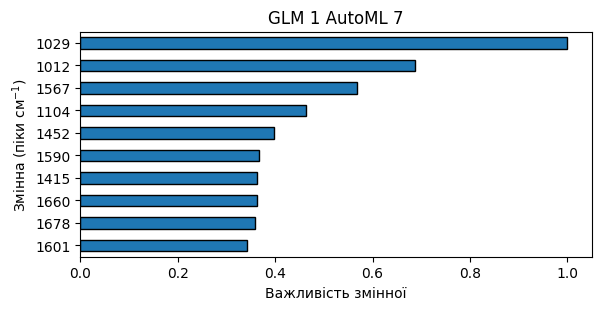

In [ ]:
# plt.figure(figsize=(6.6, 3))
varimp.plot(kind='barh', edgecolor='k', legend=False, figsize=(6.6, 3))
plt.ylabel('Змінна (піки см$^{-1}$)')
plt.xlabel('Важливість змінної')
plt.title("GLM_1_AutoML_7".replace("_", " "))
plt.gca().invert_yaxis()
plt.subplots_adjust(bottom=0.13)
# plt.savefig("../figures/variable_importance.pgf")

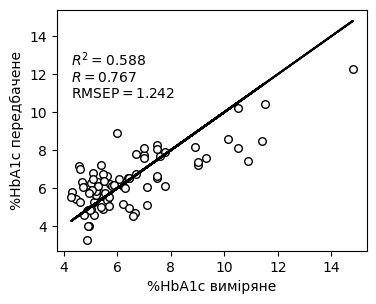

In [ ]:
test, predicted = pd.read_csv("../data/test_predict.csv").iloc[:, 1:].to_numpy().T
fig, axs = plsr_r2_plot(test, predicted)
fig.set_size_inches(4, 2.8)
axs.set_xlabel("%HbA1c виміряне")
axs.set_ylabel("%HbA1c передбачене")
plt.subplots_adjust(bottom=0.14, top=1)
# fig.savefig("../figures/h2o_predicted.pgf", transparent=True)

In [ ]:
age.mean()

59.386986301369866

In [ ]:
age.std()

16.643859222600092

$R = 0.49$
$p < 0.00001$
$y = 9.95x + 3.52$


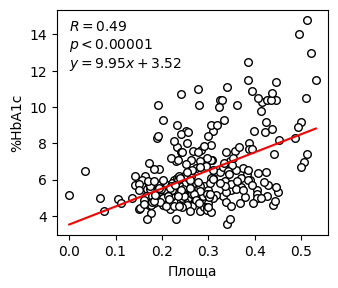

In [ ]:
fig, ax = corr_plot(areas[1029].to_numpy(), hba1c)
fig.set_size_inches(3.5, 3)
ax.set_xlabel("Площа")
ax.set_ylabel("%HbA1c")
plt.subplots_adjust(bottom=0.13)
# plt.savefig("../figures/1029_HbA1c.pgf", transparent=True)

$R = 0.57$
$p < 0.00001$
$y = 33.04x + 4.52$


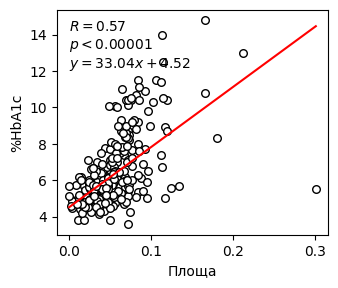

In [ ]:
fig, ax = corr_plot(areas[1012].to_numpy(), hba1c)
fig.set_size_inches(3.5, 3)
ax.set_xlabel("Площа")
ax.set_ylabel("%HbA1c")
plt.subplots_adjust(bottom=0.13)
# plt.savefig("../figures/1012_HbA1c.pgf", transparent=True)

$R = -0.27$
$p < 0.00001$
$y = -4.16x + 10.81$


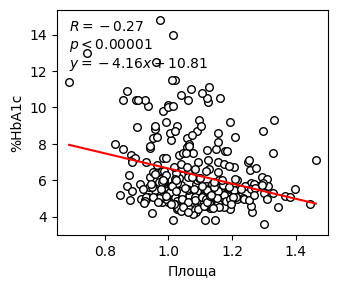

In [ ]:
fig, ax = corr_plot(areas[1567].to_numpy(), hba1c)
fig.set_size_inches(3.5, 3)
ax.set_xlabel("Площа")
ax.set_ylabel("%HbA1c")
plt.subplots_adjust(bottom=0.13)
# plt.savefig("../figures/1567_HbA1c.pgf", transparent=True)

In [ ]:
# areas.to_csv("areas_vn.csv")
areas

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1674,1678,1683,1687,1694,1699,1703,1717,HbA1c,age
0,0.057270,0.338554,0.259519,0.769326,3.022163,1.686918,1.018686,1.828520,0.727539,1.002704,...,1.016729,0.530179,0.400571,0.634604,0.406403,0.061741,0.214844,0.003022,7.50,70
1,0.038489,0.217303,0.236097,0.853087,2.878546,1.485644,0.900393,1.429176,1.171396,1.118969,...,1.019072,0.552896,0.408270,0.593819,0.491599,0.048479,0.213299,0.008020,5.62,54
2,0.020624,0.134601,0.261608,0.674886,2.299937,1.693079,0.802441,1.451517,1.008509,1.155718,...,0.965032,0.660489,0.233814,0.884439,0.399766,0.061636,0.234571,0.006338,5.00,80
3,0.051829,0.354164,0.154720,0.720877,3.222098,1.574013,0.757262,2.104519,0.625120,0.876565,...,0.932666,0.609558,0.345988,0.587970,0.494845,0.076639,0.209516,0.010266,5.52,47
4,0.033645,0.229756,0.316005,0.687343,2.639979,1.770907,0.903204,1.519325,0.881894,1.182416,...,0.830597,0.792829,0.221272,0.734738,0.361847,0.047945,0.158615,0.010212,7.00,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.009716,0.396574,0.256892,0.823245,2.151945,1.576390,0.896806,1.808626,0.701999,1.590474,...,1.066135,0.732815,0.374206,0.628650,0.466081,0.029568,0.147975,0.015264,4.72,83
288,0.045046,0.193512,0.326457,0.717954,2.729666,1.708676,0.851797,1.866335,0.678594,1.138401,...,0.957887,0.619530,0.414603,0.723826,0.742896,0.026698,0.226456,0.020967,5.55,53
289,0.052843,0.184718,0.304757,0.738113,2.705382,1.633483,0.974378,1.960568,0.481497,1.132461,...,1.093480,0.582087,0.220159,0.848639,0.485824,0.026519,0.193376,0.009221,5.17,46
290,0.044590,0.302832,0.180929,0.758638,2.992269,1.221852,1.135284,1.247439,1.054419,0.881985,...,1.036042,0.682174,0.292818,0.714819,0.410055,0.079687,0.283473,0.005985,5.20,58


In [ ]:
areas.drop(columns=['HbA1c'])

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1667,1674,1678,1683,1687,1694,1699,1703,1717,age
0,0.057270,0.338554,0.259519,0.769326,3.022163,1.686918,1.018686,1.828520,0.727539,1.002704,...,1.583135,1.016729,0.530179,0.400571,0.634604,0.406403,0.061741,0.214844,0.003022,70
1,0.038489,0.217303,0.236097,0.853087,2.878546,1.485644,0.900393,1.429176,1.171396,1.118969,...,1.596467,1.019072,0.552896,0.408270,0.593819,0.491599,0.048479,0.213299,0.008020,54
2,0.020624,0.134601,0.261608,0.674886,2.299937,1.693079,0.802441,1.451517,1.008509,1.155718,...,1.577566,0.965032,0.660489,0.233814,0.884439,0.399766,0.061636,0.234571,0.006338,80
3,0.051829,0.354164,0.154720,0.720877,3.222098,1.574013,0.757262,2.104519,0.625120,0.876565,...,1.655148,0.932666,0.609558,0.345988,0.587970,0.494845,0.076639,0.209516,0.010266,47
4,0.033645,0.229756,0.316005,0.687343,2.639979,1.770907,0.903204,1.519325,0.881894,1.182416,...,1.549134,0.830597,0.792829,0.221272,0.734738,0.361847,0.047945,0.158615,0.010212,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.009716,0.396574,0.256892,0.823245,2.151945,1.576390,0.896806,1.808626,0.701999,1.590474,...,1.521634,1.066135,0.732815,0.374206,0.628650,0.466081,0.029568,0.147975,0.015264,83
288,0.045046,0.193512,0.326457,0.717954,2.729666,1.708676,0.851797,1.866335,0.678594,1.138401,...,1.512198,0.957887,0.619530,0.414603,0.723826,0.742896,0.026698,0.226456,0.020967,53
289,0.052843,0.184718,0.304757,0.738113,2.705382,1.633483,0.974378,1.960568,0.481497,1.132461,...,1.511817,1.093480,0.582087,0.220159,0.848639,0.485824,0.026519,0.193376,0.009221,46
290,0.044590,0.302832,0.180929,0.758638,2.992269,1.221852,1.135284,1.247439,1.054419,0.881985,...,1.609439,1.036042,0.682174,0.292818,0.714819,0.410055,0.079687,0.283473,0.005985,58


In [ ]:
# fwhms.to_csv("fwhms_vn.csv")
fwhms

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1674,1678,1683,1687,1694,1699,1703,1717,HbA1c,age
0,13.886880,18.591387,18.738171,28.886620,40.981000,30.216403,24.561375,33.748000,21.565163,46.284000,...,8.678000,7.576598,7.232000,9.161000,8.451616,4.339000,12.853902,7.039936,7.50,70
1,9.573572,16.653756,18.320000,33.735456,45.266511,30.856000,24.476658,31.338000,25.553000,49.128993,...,8.517482,6.750000,6.268000,8.678000,9.160000,3.375000,11.873263,7.123978,5.62,54
2,9.922805,11.571000,17.357000,26.289124,38.570000,31.646139,23.624000,29.892000,23.946429,49.658000,...,8.614385,7.232000,5.304000,10.939310,8.678000,4.189588,13.981000,4.771732,5.00,80
3,13.017000,22.178000,17.319681,28.751626,44.837000,30.856000,22.974848,37.124000,21.213000,46.766000,...,8.196000,7.714000,6.565236,9.412083,8.678000,4.339000,12.053000,5.759095,5.52,47
4,11.571000,15.238921,19.273124,27.267449,39.534000,33.163750,24.588000,32.222566,23.142000,53.299199,...,8.196000,7.714000,5.304000,10.429684,8.678000,4.270801,12.842381,12.523820,7.00,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,3.754494,21.695000,17.839000,26.009177,39.508974,29.892000,23.112127,35.511131,21.694795,58.337000,...,8.196000,7.714000,6.268000,9.410055,9.435417,3.375000,11.474928,6.750000,4.72,83
288,12.053000,13.982000,22.057094,28.816476,42.284748,32.302000,24.548242,34.632891,21.213000,48.937982,...,8.526029,7.211077,6.750000,9.603029,10.558433,3.375000,12.039896,11.089000,5.55,53
289,14.874215,14.869058,20.550925,29.287179,39.535000,31.338000,25.876918,35.094527,18.192141,52.070000,...,8.678000,7.232000,5.304000,10.607000,9.628530,3.375000,11.860688,7.489740,5.17,46
290,11.089000,19.767000,18.803000,28.837045,43.719563,27.894825,27.964000,28.927000,24.589000,45.802000,...,8.185972,7.232000,6.268000,9.943609,8.533444,4.339000,13.017000,4.763034,5.20,58


In [ ]:
# amplitude.to_csv("amplitude_vn.csv")
amplitude

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1674,1678,1683,1687,1694,1699,1703,1717,HbA1c,age
0,0.156655,1.019064,0.760890,2.297445,9.190201,4.862774,2.888612,5.281340,2.084030,2.883201,...,2.810724,1.470802,1.103550,1.780576,1.155041,0.172918,0.599738,0.009232,7.50,70
1,0.111276,0.629608,0.671900,2.518066,8.472002,4.180982,2.488385,3.962833,3.219103,3.146324,...,2.751438,1.493006,1.105287,1.617580,1.368005,0.133249,0.617342,0.021695,5.62,54
2,0.054372,0.377151,0.736292,1.928209,6.601768,4.730929,2.191890,3.978287,3.157978,3.217555,...,2.572608,1.775159,0.624333,2.410571,1.102528,0.166168,0.635322,0.017471,5.00,80
3,0.161517,1.090326,0.451763,2.185624,9.755705,4.555073,2.148272,6.053586,1.762590,2.529853,...,2.581582,1.682491,0.955842,1.620646,1.419157,0.215479,0.584946,0.043780,5.52,47
4,0.086884,0.642376,0.878131,1.929389,7.673289,4.850988,2.421478,4.089736,2.341657,3.237647,...,2.172306,2.105577,0.578435,1.961178,0.978031,0.126370,0.414414,0.039171,7.00,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.025546,1.140704,0.698660,2.299676,5.623453,4.215602,2.357417,4.809933,1.829965,4.307906,...,2.757880,1.924072,0.959353,1.667096,1.243467,0.076409,0.496236,0.042551,4.72,83
288,0.122938,0.568028,0.969094,2.141102,8.184595,4.944787,2.411502,5.324035,2.131642,3.279145,...,2.635697,1.718984,1.141074,2.047124,2.153487,0.074055,0.647369,0.059117,5.55,53
289,0.143470,0.766815,0.893076,2.190665,8.012306,4.682360,2.748520,5.561175,1.334440,3.254558,...,3.007206,1.599023,0.607660,2.347977,1.384658,0.072386,0.538932,0.025040,5.17,46
290,0.133462,0.902743,0.521633,2.229926,8.849600,3.447363,3.182980,3.478283,2.944304,2.491765,...,2.838057,1.863639,0.796065,1.948076,1.144137,0.219442,0.780903,0.017087,5.20,58


In [ ]:
wavenumbers['HbA1c'] = hba1c
wavenumbers['age'] = age
# wavenumbers.to_csv("wavenumber_vn.csv")
wavenumbers

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1674,1678,1683,1687,1694,1699,1703,1717,HbA1c,age
0,1015.381977,1029.951588,1042.857069,1054.071404,1080.462219,1106.132828,1125.820067,1156.833457,1170.571564,1200.761525,...,1674.197037,1679.478507,1683.009941,1687.772180,1694.095456,1698.970560,1703.024063,1716.362213,7.50,70
1,1016.003754,1030.948773,1044.993393,1055.057504,1081.294445,1105.565393,1125.870759,1155.511007,1169.665326,1201.302674,...,1674.194621,1679.366345,1682.975515,1687.541468,1694.039312,1698.960167,1702.900728,1713.026079,5.62,54
2,1017.461988,1030.075687,1043.066735,1055.067000,1080.070897,1105.429565,1126.092418,1156.419998,1170.334597,1202.726093,...,1674.186928,1679.673878,1683.101861,1687.436275,1694.441504,1699.068623,1703.814999,1714.775362,5.00,80
3,1014.202020,1029.838256,1043.995227,1053.235617,1080.390052,1106.746674,1126.001915,1157.533414,1170.923522,1201.758034,...,1673.956655,1679.335166,1683.020301,1687.685432,1694.246993,1698.908475,1703.383065,1714.303258,5.52,47
4,1016.015000,1029.707964,1042.660260,1055.066536,1080.153797,1105.995210,1125.767483,1156.194117,1170.230659,1200.982662,...,1673.962374,1679.484871,1683.005319,1687.347213,1694.236097,1698.926325,1703.506441,1720.731277,7.00,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,1013.739408,1030.818844,1043.292694,1053.678576,1080.663888,1107.620287,1125.930559,1157.430764,1170.485987,1203.774368,...,1673.923013,1679.306562,1683.023968,1687.844035,1694.114559,1698.990289,1703.742794,1714.615208,4.72,83
288,1015.815544,1029.837321,1042.714608,1054.165974,1080.212324,1105.961067,1125.742002,1157.324146,1170.669904,1200.935973,...,1674.161494,1679.357302,1682.935258,1687.648240,1694.043269,1698.903151,1702.849625,1712.950737,5.55,53
289,1016.862934,1029.754990,1042.905813,1055.066492,1080.707752,1105.967884,1125.675208,1158.047816,1170.918073,1199.624444,...,1674.153003,1679.539992,1683.023126,1687.104962,1694.430555,1698.957633,1702.952496,1712.958529,5.17,46
290,1014.412073,1029.750450,1042.790754,1053.753574,1080.977143,1105.803405,1125.430843,1155.351083,1169.621103,1199.907937,...,1673.956193,1679.229066,1682.973163,1687.587147,1694.465208,1698.936771,1703.241229,1714.703568,5.20,58


In [ ]:
wavenumbers.corr()['HbA1c'].abs().sort_values(ascending=False).head(10)

0
HbA1c    1.000000
1563     0.377498
1717     0.374400
1683     0.371547
1415     0.361342
1687     0.358671
1439     0.348609
1624     0.313300
1660     0.294935
1617     0.288593
Name: HbA1c, dtype: float64

In [ ]:
path = "../data/fits/fit_1250_2750_params1/"

areas = []
fwhms = []
wavenumbers = []
amplitude = []
gamma_g = []
gamma_l = []
eta = []

hba1c = []
hb = []
rbcs = []


for file in os.listdir(path):
    filename = os.path.splitext(file)[0]
    
    values = filename.split("_")
    hba1c_value = values[2]
    hb_value = values[3]
    rbc_value = values[4]
    
    hba1c.append(float(hba1c_value))
    hb.append(float(hb_value))
    rbcs.append(float(rbc_value))
    
    result = pd.read_csv(os.path.join(path, file)).iloc[:, 1:]
    
    areas.append(result['area'].to_numpy())
    fwhms.append(result['FWHM'].to_numpy())
    wavenumbers.append(result['wavenumber'].to_numpy())
    amplitude.append(result['amplitude'].to_numpy())

    gamma_g.append(result['gamma_gauss'].to_numpy())
    gamma_l.append(result['gamma_lorentz'].to_numpy())
    eta.append(result['eta'].to_numpy())

hba1c = np.array(hba1c)

wavenumbers = pd.DataFrame(wavenumbers)
areas = pd.DataFrame(areas, columns=columns) * 100
fwhms = pd.DataFrame(fwhms, columns=columns)
amplitude = pd.DataFrame(amplitude, columns=columns)

In [ ]:
areas['HbA1c'] = hba1c
areas['Hb'] = hb
areas['RBCs'] = rbcs
areas['GL'] = areas['Hb'] * areas['HbA1c'] * 0.01
areas = areas.dropna()

In [ ]:
areas.corr()['RBCs'].abs().sort_values(ascending=False).head(15)

0
RBCs    1.000000
Hb      0.798485
1586    0.318255
1640    0.275822
GL      0.257367
1401    0.224676
1652    0.218822
1644    0.197496
1656    0.192238
1582    0.188827
1557    0.173756
1636    0.173567
1578    0.171116
1703    0.158704
1169    0.152112
Name: RBCs, dtype: float64

In [ ]:
areas

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1683,1687,1694,1699,1703,1717,HbA1c,Hb,RBCs,GL
0,3.118735,0.751125,0.414284,0.523317,2.183530,6.647558,1.022772,0.749548,3.207036,0.635124,...,0.430914,0.544783,0.290770,0.128715,0.201962,0.383135,9.1,135.0,4.7,12.285
1,2.876526,0.284631,0.426380,0.408844,4.017683,3.453227,1.440969,1.046304,3.872051,0.394538,...,0.453390,0.527006,0.325498,0.096643,0.188734,0.395486,5.1,125.0,3.8,6.375
2,0.100040,0.567132,0.073309,0.684010,0.832787,4.460379,0.614461,0.667632,1.377494,1.243540,...,0.308710,0.767642,0.333097,0.160674,0.206869,0.007374,6.0,150.0,4.9,9.000
3,0.086611,0.242780,0.080954,1.051105,2.867368,1.765756,0.692437,1.073542,1.959109,0.734499,...,0.235498,0.892256,0.285638,0.042116,0.283622,0.028633,5.1,125.0,3.8,6.375
4,1.520125,2.877452,0.189537,0.450521,3.376075,5.170605,0.970133,1.148875,2.300321,0.352254,...,0.262361,0.535701,0.329021,0.057355,0.181947,0.507178,7.7,135.0,3.6,10.395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2.957213,0.146829,0.018966,2.998939,2.428045,2.776395,0.558065,5.260582,0.184932,2.152660,...,0.176192,0.836933,0.195307,0.038368,0.274871,0.375586,6.9,179.0,5.7,12.351
106,3.206077,0.113012,0.200507,0.688855,4.057047,2.321086,1.781145,1.676595,1.862468,0.260275,...,0.456345,0.510012,0.348072,0.137882,0.261571,0.314210,6.2,155.0,5.1,9.610
108,1.430480,1.816035,0.221203,1.407792,3.250857,2.416574,1.702200,2.001017,1.963743,0.454187,...,0.361916,0.567091,0.389727,0.113341,0.236811,0.306762,5.4,166.0,5.8,8.964
109,1.981380,1.439015,0.515325,0.692001,2.794297,1.420056,5.285192,0.872323,1.236957,0.047403,...,0.400912,0.536771,0.403115,0.093638,0.220253,0.433724,6.0,150.0,4.9,9.000
